In [1]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00


In [2]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from efficientnet.keras import EfficientNetB3, EfficientNetB4, EfficientNetB5

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Set the data path and categories
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 256
data = []
label = []

In [4]:
# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [5]:
data = np.array(data) / 255.0
data_rgb = np.repeat(data[..., np.newaxis], 3, -1)
label = np.array(label)
new_label = np_utils.to_categorical(label)

# Split the data into train, test, and validation sets
x_train, x_test, y_train, y_test = train_test_split(data_rgb, new_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

# Define the data generators
datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)

In [6]:
# Define the model architecture
model = Sequential()

# EfficientNet B3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
# EfficientNet B4
# base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
#noisy-student' or weights='advprop
# EfficientNet B5
#base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

model = Sequential()
model.add(base_model)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.3))
#model.add(Dense(len(categories), activation='softmax')

# Add additional layers to increase complexity
#model.add(GlobalAveragePooling2D())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(len(categories), activation='softmax'))

# Add additional layers to increase complexity
#model.add(GlobalAveragePooling2D())
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(len(categories), activation='softmax'))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(categories), activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

44107200/44107200 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 8, 8, 1536)       10783528  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                       

In [7]:
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [8]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [9]:
# Train the model
history = model.fit(train_generator,
                    epochs=90,
                    validation_data=val_generator,
                    #callbacks=[checkpoint])
                    callbacks=[checkpoint, early_stopping])

Epoch 1/90


2023-06-14 12:50:50.706591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - ETA: 0s - loss: 1.5796 - accuracy: 0.2831
Epoch 1: val_accuracy improved from -inf to 0.24848, saving model to /kaggle/working/model2.h5
37/37 [==============================] - 60s 952ms/step - loss: 1.5796 - accuracy: 0.2831 - val_loss: 1.5637 - val_accuracy: 0.2485
Epoch 2/90
37/37 [==============================] - ETA: 0s - loss: 1.4768 - accuracy: 0.3065
Epoch 2: val_accuracy improved from 0.24848 to 0.27879, saving model to /kaggle/working/model2.h5
37/37 [==============================] - 30s 809ms/step - loss: 1.4768 - accuracy: 0.3065 - val_loss: 1.5558 - val_accuracy: 0.2788
Epoch 3/90
37/37 [==============================] - ETA: 0s - loss: 1.3565 - accuracy: 0.3481
Epoch 3: val_accuracy did not improve from 0.27879
37/37 [==============================] - 29s 762ms/step - loss: 1.3565 - accuracy: 0.3481 - val_loss: 1.5364 - val_accuracy: 0.2788
Epoch 4/90
37/37 [==============================] - ETA: 0s - loss: 1.2370 - accuracy: 0.

In [15]:
# Load the best weights
model.load_weights('/kaggle/working/model2.h5')

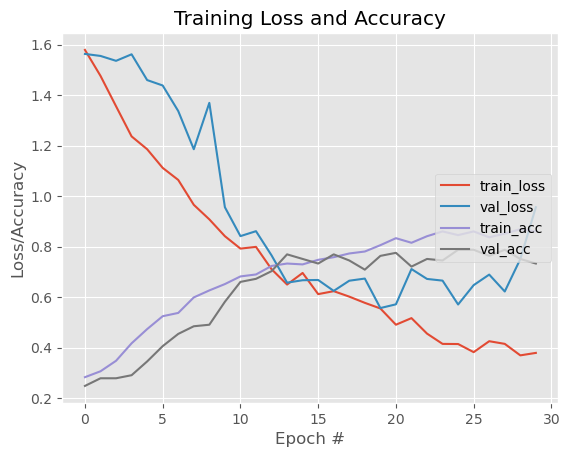

In [11]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("EfficientNet_Model")

In [12]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

# Get the predictions for the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(y_test, axis=1), predicted_labels)
print(report)

Test loss: 0.5663549304008484
Test accuracy: 0.7969697117805481
11/11 [==============================] - 4s 131ms/step
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       105
           1       0.89      0.96      0.92        50
           2       0.81      0.94      0.87        32
           3       0.71      0.50      0.59        48
           4       0.83      0.87      0.85        95

    accuracy                           0.80       330
   macro avg       0.80      0.80      0.79       330
weighted avg       0.79      0.80      0.79       330



<Figure size 640x480 with 0 Axes>

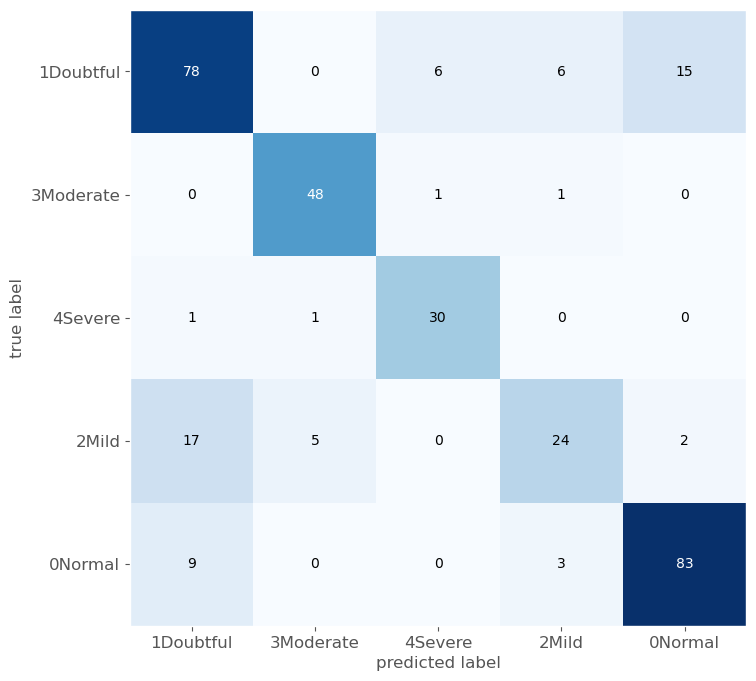

In [13]:
# Plot the confusion matrix
test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

1/1 [==============================] - 1s 759ms/step
A.I predicts: 3Moderate
Correct prediction for label 1 is 3Moderate


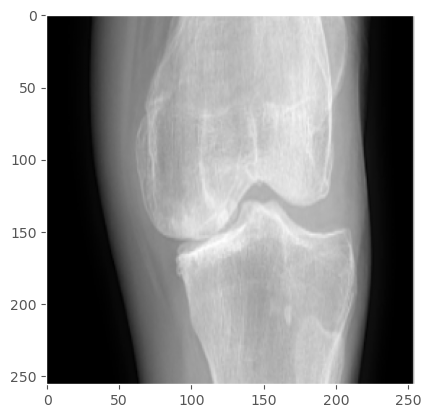

In [14]:
# Select a single image from the test set for prediction
X = 32
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(y_test[X]), 'is', categories[np.argmax(y_test[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()